# Using the HackRF One: Detecting Various Transmissions

The HackRF One gadget is a useful tool to receive, transmit, and work with signals in the radio and microwave bandwidths. Software-defined radio programs such as GNU Radio complement HackRF One by providing accessibility and a convenient interface to serve many purposes. Manual signal processing is also viable through the use of the hackrf_transfer command, though that requires processing raw I/Q data. A quick guide on processing raw I/Q data can be found in the titular file in this repository.

This tutorial is aimed to provide a basic understanding of how to use HackRF One, focusing on receiving and processing cellphone signals, wifi signals, and targeting specific frequencies. Additional focus will be on introducing GNU Radio and its uses with HackRF One.

For detailed information on hackrf, here's the full original documentation: https://github.com/mossmann/hackrf

## From the Command Line: hackrf_transfer

**hackrf_transfer -r filename.bin -f 1575000000 -s 20000000**

The above basic command takes in data from the hackrf hardware and store it in the filename.bin file (it can be freely named). hackrf_transfer can be used to either emit or receive information; we'll be focusing on receiving and storing information. When ran, hackrf keeps receiving (or transmitting) signals around the given frequency without a time limit. The user has to manually stop the process.

*Parameters*

-r: naming the file  
-f: the central frequency of the sampled band  
-s: sampling rate.   
-b: baseband width; same as sampling_rate by default   

Additional parameters and descriptions, such as gain options, can be found at this convenient third-party site: http://manpages.ubuntu.com/manpages/xenial/man1/hackrf_transfer.1.html

## The I/Q Data

I/Q is the form of data that HackRF One outputs; I is for in-phase while Q is for quadrature (side note: unintuitively, I is "real" while Q is "imaginary"). I/Q data represents a 2D projection of 3D mathematics behind the signals. The nature of the data slightly beyond the scope of this tutorial. The main aspect to be concerned with here is the method for processing the data. 

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

def bin_to_np(filename):
    """
    returns values in the form of a numpy array from 8-bit integer data
    """
    npdata = np.array(np.fromfile(filename, dtype=np.int8))
    return npdata

Converting raw binary I/Q data into the form of numpy arrays of 8-bit integers is simple; the above line of code does just that. Additional work, however, needs to be done on the numpy array to make sense of it. First, let's do a sanity check to make sure that our numpy array is what we expect:

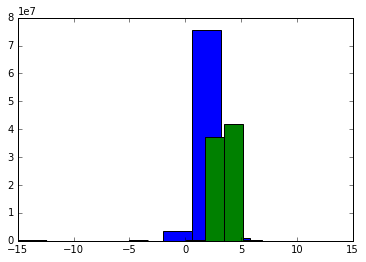

In [2]:
def gauss_check(npdata):
    """
    creates histograms representing the input I/Q Data
    """
    real = npdata[0::2]
    imag = npdata[1::2]
    plt.hist(real)
    plt.hist(imag)
    plt.show()

gauss_check(bin_to_np("2445.0.bin"))

Note: In python, the syntax "::a" corresponds to incrementation; in this case, "0::2" means "every other element beginning with the first element."

The graph looks roughly composed of gaussian distributions, which is what we would like to see. There's two histograms, one each for the real and the imaginary parts of the I/Q data. We expect gaussian distributions because of we know the incoming signals that we set up to receive have characteristic sinusoidal properties that center around certain values. T

With our data confirmed to be legitimate, we move to the crux of the code: performing fourier transforms and reducing the data.

## Data Processing and Plotting

Even with our data in the form of a numpy array, it is still far from our desired set of values used to generate our final plot. The data is still defined by its I and Q values rather than the familiar fourier-transformed power values. Riddled with noise, the data must also be filtered before we plot it. For my method, I simply took the median of a number of points and applied that across my entire array:

In [3]:
def reducer(data, m):
    """
    takes in and then outputs a numpy array of the same dimensions after applying a median to every m number of points across the entire array
    """
    rspec = []
    i = 0
    for datum in data:
        if i < m:
            rspec.append(np.median(data[0:i+m]))
            i += 1
        elif i >= (len(data) - m):
            rspec.append(np.median(data[i-m:]))
            i += 1
        else:
            rspec.append(np.median(data[i-m:i+m]))
            i += 1
    return rspec

The function begins with the initial element and then increments to the next element to be centered on. The first two else/if statements are to account for the initial and terminating parts of the numpy array; to maintain the same dimensions for the output as the input, the function appends a value to the output array even if there are less than m elementing centering around the element at hand.

The result is a much less noisy set of data with the noise floor mitigated and many noise-produced peaks removed. The side effect of taking medians is that legitimate peaks also have their values mitigated, though that is insiginificant since part of our goal is to merely uniquely identify them - their relative amplitudes should remain roughly constant. 

We do not use this data-reducing function immediately. We will call this function from the next one, which is the primary function in converting our data into a final plot featuring power as a function of frequency.

In [4]:
def transform(filename, fftsize, m, xax=0, yax=1):
    """
    takes input binary file and apply the bin_to_np function to it;
    elements of the resulting array are changed to the form complex numbers to be applied by an fft;
    the array is split into smaller arrays by a given fftsize and a final arra is formed from averages of those arrays;
    a fourth of the final array is inputed into the reducer function 
    """
    npdata = bin_to_np(filename)
    row = len(npdata) / fftsize
    data = npdata.reshape(int(row), fftsize)
    power_arr = []
    for row in data:
        cplex = row[0::2] + row[1::2] * 1j
        cfft = np.fft.fft(cplex)
        cfft[0] = cfft[1]
        sfft = np.fft.fftshift(cfft)
        power_arr.append(abs(sfft)**2)
    indices_arr = np.swapaxes(power_arr, xax, yax)
    power_avg = []
    for array in indices_arr:
        power_avg.append(np.average(array))
    rdata = reducer(power_avg[int(3*fftsize/16):int(5*fftsize/16)], m)
    return rdata

Let's break down this function part by part:

First, **it converts the values of the input binary data to be stored in an numpy array via bin_to_np.**

Second, **it segments the array by a given fft size.** We must first decide on an fft size; hackrf by default stores data in numbers of powers of two so an fft size that's a power of two conveniently suits our purposes. The .reshape command segments our data into [1st_arg] number of array of [2nd_arg] elements each. In our case, the second argument is our input fftsize while the first is the original array size divided by the fftsize.

Next, **we change our data into the form of complex numbers, which is then used for the fourier transform**. Numpy conveniently allows us to do that: I added each I component with its Q component (the Q component is de-facto imaginary by the 1j factor -- j is the imaginary value i in python). The fourier transform is in several steps. After the initial appliance of np.fft.fft, we perform a shift. The fftshift function shifts the zero-frequency component of the data to the center of the data. In addition, I also changed the value of cfft[0] to be that of cfft[1]. This step is to erase the direct current spike of the data. Due to internal hardware activity, hackrf (and many other tools) generates a large, central spike that can often be difficult to remove. I simply changed the value of the peak to that of a nearby index. Any method that can remove or mitigate the spike without significantly and adversely affecting the plot is fine.

Finally, now that we have an array of arrays, we need to mold that into our final set of data to plot. The inner arrays are simply different iterations of the same data of fftsize/2 each. Because we performed the fourier transform in which each complex value is a sum of two values, our input fftsize is actually twice the size of the actual fft. **What we need to do with the arrays is to perform an axes swap: np.swapaxes changed the number of arrays to be fftsize/2 each with a row number of elements. This way, we can average out each set of index-sharing element** to get a final, average array. We apply that array to the reducer function to smooth out the data.

### Sampling Rate and Baseband: Curved Noise Floor

Hackrf sets the baseband to be the same as the input sampling rate by default, though the baseband value can be set manually. Plotting a frequency band that's the same size as the sampling rate can pose problems, however. The hardware produces "curved noise floor" due the response to the signal centering around the input sampled frequency. To "flatten" the noise floor, I set the baseband to be half of that of the sampling rate and adjusted my code accordingly to avoid curving at the edges of the plot. My code above processes only half the data in the final step; whereas the averaged final array fftsize/2 number of values, I used only the central values -- from 3/16(fftsize) to 5/16x(fftsize). You would normally use 1/8 to 3/8 instead; I used an even smaller set of values because of the particular nature of my file. The result is a plot that isolates the central, flat-noise region of the data (see below).

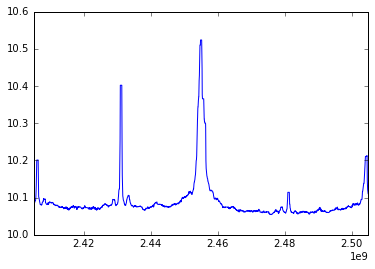

In [5]:
def plotspec(filename, fftsize, m, start_freq, end_freq):
    y = transform(filename, fftsize, m)
    x = np.linspace(start_freq, end_freq, len(y))
    plt.xlim(start_freq, end_freq)
    plt.plot(x, np.log(y))
    plt.show()
    
plotspec("2445.0.bin", 32768, 20, 2405000000, 2505000000)

The plotting function draws primary upon the transform function, which provides the data for the y-axis. What we need to do is to simply identify the values to plot for the x-axis to make our power spectrum. The frequency values should be spaced apart by increments that corresponds to the number of power values. To do that, we simply use the np.linspace function and apply the length of the array used for the y-axis to space it. The limits of the x-axis should match our x-axis values. For my plot, I chose the relevant baseband to be 10 MHz, centered around 2.445 GHz, so the x-axis limits should be 2.405 GHz and 2.505 GHz.

# Working with SDR Tools: GNU Radio

GNU Radio is a very useful tool for working with radio signals among other types of information. It does have a somewhat learning curve, so I recommend going through the provided tutorial at gnuradio.org, where you can find also a comprehensive manual for the program. For our purposes, we want to know how to use GNU Radio to do the type of work that's represented by our code -- converting and processing data and then plotting the result. 

After downloading the program, you can access the interface from the command line with gnuradio-companion. 

### Blocks and the Flow Graph

Blocks are the foundation of building a process in GNU Radio and a flow graph is the design that emcompasses the blocks (see image below). Each block is a component that functions as a piece of code. Blocks can represent a variable, an action, a source, a sink, and many other forms of interactions. When you generate a file from the gnuradio-companion interface, a complementary python file is also generated that contains the underlying code of your blocks.

Let's look at an example:

<img src="flowgraph.png">

There are two primary ways to get our plot from GNU Radio: we can either we can directly funnel the data into the program real-time or we can store the data first in our file like we have been doing. The search bar (magnifying glass) in the toolbar of the interface provides a vast range of block options to choose from. We have to select blocks that correctly correspond with our goals and tools. 

Before we get the crux of the chart, it's important to note the blocks at the top. The options block exists by default and is the primary method used to identification. Your .grc file name will be generated according to what's in this block and the type of your sink should match the "Generate Options" (WX GUI in our case) in this block. You can create as many variable blocks are you want to store variables in (think of them as global variables in python). 

The former method requires you to have the hardware at hand. In the example above, there are two grayed blocks; those were not being used at the time and were thus disabled. The leftmost gray block, "osmocom source," is main component of the former method. Tje block tells the program that input data is directly obtained from the hardware; that specific block also recognizes that our input data is in the form 8-bit signed binary because it corresponds to our hardware. The sink is the final step for the resulting signal. In my case, I used an FFT sink for the fourier transform and to output an fft plot. For directly inputting information from hardware, getting the result is done in this one step.

If you want to store the input data in a file for future use or for any other reason, several more steps are involved. Unlike the first method, the source block, "file source," is responsibly for only the fact that our source is in a file -- it does not process what's in it. We have to manually let GNU Radio know what we want to ultimately get from the input and fortunately, there are plenty of block options that can potentially be useful for us:

**Uchar to Float**: Converts our specific binary type data to floats
**Deinterleave**: Splits the input into real and imaginary parts, similarly to the "::n" in numpy
**Float to Complex**: Converts floats to complex numbers; m + n x 1j
**Add Const**: Adds a value that numerically converts the 8-bit signed binary to our desired numbers. Here, the constant is -128-128j; 128 is due to the 8-bit (2^7 = 128 with the 8th bit being the negative or positive sign). 

The follow is what is displayed from the output sink should you run the flow chart:

<img src="cellband810_2.png">

GNU Radio is a flexible tool that brings traditional code into a succint form. It provides many ways to process and output data -- you can also view the output as a waterfall plot in real-time if you have the hardware ready. There are limits, however. For example, GNU Radio isn't well-suited for large fft sizes, which can cause lag. There are also many statiscal tools in the plotting interfact that allows you to adjust parameters, such as gains and the amount of averaging for instance. There are plenty of third-party sites, code, and tools that work with GNU Radio. They can be used as a good sources of documentation.

These are the basics of using hackrf with python and with GNU Radio. The final section of this notebook helps with improving efficiency and methods.

# Wide-band Receiving: Only One Line of Code

So far, the code I presented is actually inefficient. Imagine that you want to make a wide-range "scan" (hackrf does not actually scan -- it can target a frequency band and receive transmissions in that range) that goes from, say 1700 to 2100 MHz, well within common cellphone transmission ranges. You would have to:

1. Receive data from the hardware and store it in a file
2. Adjust your code for each frequency band
3. Plot each band or append each band and then plot the

In addition, hackrf uses only several fixed baseband widths and sampling rates, hard-limiting your ability to do a wide "scan." Fortunately, it's possible to alter your code so that you have to change only one line of code to do all of the above. The following method will introduce two options:

- **Plot a wide frequency band in one step**
- **Plot any frequency band (as allowed by time and by your hardware) by changing only one line of code**

Let's introduce my initial functions in a new form (the reducer function is still the same):

In [6]:
import os

def hackrf_transfer(init_freq, bands, samp_rate, timeout=5, lgain=24, gain=30):
    """
    the command you give to hackrf to receive (or transmit) signals, but in a python function
    this function can take data inputs from multiple bands without manually changing values
    """
    i = 0
    while i < bands:
        center_freq = init_freq + (i*samp_rate/2)
        os.system("timeout " + str(timeout) +"s hackrf_transfer -r" + str(center_freq/1000000) + ".bin" + " -f" + str(int(center_freq)) + " -s" + str(samp_rate) + " -l" + str(lgain) + " -g" + str(gain) + " -b" + str(int(samp_rate/2)))
        i += 1

def input_data(init_freq, bands, transfer, samp_rate, dtype=np.int8):
    """
    this function corresponds to bin_to_np in the previous code;
    this function checks whether or not we want new data from the hardware; if yes, it runes hackrf_transfer
    """
    if transfer:
        hackrf_transfer(init_freq, bands, samp_rate)
    binfiles = []
    i = 0
    while i < bands:
        center_freq = init_freq + (i*samp_rate/2)
        binfiles.append(str(center_freq/1000000) + ".bin")
        i += 1
    npdata = []
    for binfile in binfiles:
        rawdata = np.fromfile(binfile, dtype)
        npdata.append(rawdata)
    return np.array(npdata)

def transform2(init_freq, bands, transfer, samp_rate, fftsize, m, xax=0, yax=1):
    """
    similar to the transform function;
    adds an additional layer of loop to account for multiple bandwidths
    """
    npdata = input_data(init_freq, bands, transfer, samp_rate)
    allavg = []
    for sample in npdata:
        row = len(sample) / fftsize
        sample = sample.reshape(int(row), fftsize)
        power_array = []
        for row in sample:
            comp = row[0::2] + row[1::2] * 1j
            cfft = np.fft.fft(comp)
            cfft[0] = cfft[1]
            sfft = np.fft.fftshift(cfft)
            power_array.append(abs(sfft)**2)
        indices_arr = np.swapaxes(power_array, xax, yax)
        power_avg = []
        for index in indices_arr:
            power_avg.append(np.average(index))
        allavg = np.append(allavg, power_avg[int(fftsize/8):int(3*fftsize/8)])
    rdata = reducer(allavg, m)
    return rdata
            
def plotspec2(init_freq, bands, transfer, samp_rate, fftsize, m):
    """
    takes into account the starting and terminating frequencies of multiple bands appended together
    """
    startfreq = init_freq - samp_rate/4
    endfreq = init_freq + samp_rate/4 + (bands-1)*samp_rate/2
    y = transform2(init_freq, bands, transfer, samp_rate, fftsize, m)
    x = np.linspace(startfreq, endfreq, len(y))
    plt.xlim(startfreq, endfreq)
    plt.plot(x, np.log(y))
    plt.show()

That's a lot of code, so let's break it down function by function:

## hackrf_transfer

This is a new function that's the foundation for this method. It makes use of the os.system function from the os module. It essentially allows you to store commands in the file and the command will execute as if from the command line when the file is ran. The hackrf_transfer command is "stored" in this function with the parameters as arguments:

- **init_freq: the central frequency of the first band**
- **bands: number of frequency bands; if the goal is to process just one band, then the value is 1**
- **samp_rate: the sampling rate; my code has the baseband width be half of the sampling_rate by default**
- **timeout: the amount of time for hackrf to run for each band**

The timeout parameter is extremely convenient because it prevents you from manually stopping hackrf at each band. The function loops *bands* number of times. The other parameters, gain and lgain, are not terribly important but can be useful if the goal involving matching gains (such as matching plot outputs on GNU Radio). 

This function is not needed if data would be directly retrieved from existing files; it would be called by the next function if the desire is to get fresh data from hackrf.

An important aspect of this function is that it names the file in the process. My code names the file after its content; for example, a file that has data centering around 885 MHz would be named "885.0.bin" by this function. This systematic nomenclature is a useful way for the next function to select files to be processed.

## input_data

The evolution of the bin_to_np function is quite different and much more complex. This function has two goals: determine whether or not to get new data and determining which files are going to get processed. 

**Flexibility of the Input Data**

The "transfer" statement takes advantage of booleans: transfer is a parameter that takes either "True" or "False" as possible values. If the input is True, then it calls upon the previous function and have hackrf retrieve new signals. If False, then the function moves on.

**Packaging the Files**

The function stores ultimately outputs an array of files. Using the init_freq and bands parameter and the systematic naming used in the first function, it determines (and can also create via calling the previous function) the files that are to be processed into the plotting function.

## transform2 and plotspec2

These functions aren't too different from the originals. There is an additional layer of for loop in the transform2 function that is used to account for multiple bands (if it's only 1 band, then it doesn't loop). Whereas the original function outputs an averaged (and reduced) data set of a frequency band, transform2 outputs an averaged data set of any number of bands by appending them together. Each DC offset spike is also processed away.

Plotspec2 takes into account the existence of possibly multiple bands for determining the endpoints of the x-axis values. It does that by referencing the init_freq value used in the first function. Because my baseband widths are always half the size of the sampling rate, the starting frequency for the x-axis is always the initial (center) frequency minus a fourth of the sampling rate. Same for the terminating frequency by adding a fourth instead and multiplying by the number of bands in baseband width increments. 

## The One Line: Calling the Plotting Function

You might have noticed that all the non-default variables are reintroduced in every function. The final, plotting function calls upon all the previous functions so that is the only function that is needed to be manually called. 

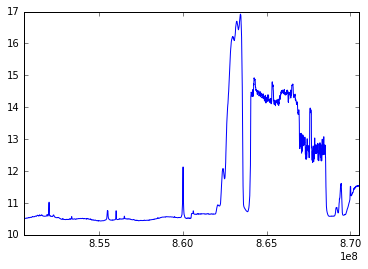

In [7]:
plotspec2(855500000, 2, False, 20000000, 32768, 20)

The above plot centers at 865.5 MHz with a total bandwidth of 20 MHz that is formed by appending two 10-MHz bands together. False would mean that I used data that is already stored in files, not freshly obtained data. 855.5 MHz is the central frequency of the first band and 2 is the number of bands. Because there are two bands, two files were used and my code incremented once to form this plot. The central frequency of the second data set is 865.5 MHz. 

# Conclusion

With that, this tutorial met its scope. We learned how to receive data from hackrf, how to process that data into plots, how to work with I/Q binary data, how to integrate GNU Radio into our work, and how to improve our code for more advanced purposes. There are many (and some more sophisticated) ways and options when it comes to working with hackrf and GNU Radio. For example, the argparse module is immensely useful for a wide range of coding purposes and can improve our efficiency even further. It allows us to work directly from the command line and create parameters to do so. If interested, seek existing professional documentation on it.

Enjoy your fun with HackRF One!